# Length of Movie in Relation to Movie Earnings

### Importing the libraries and data provided to start visualizing and previewing the data that will be used in the analysis.

In [1]:
#Importing libraries that will be used
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sqlite3

In [2]:
#Importing movie budgets and previewing data
df_gross = pd.read_csv('../../zippedData/tn.movie_budgets.csv.gz')
df_gross.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Taking a preview of the data that was imported so we can search for any missing values. This data will be joined with the SQL database im.db later so we can run queries more accurately.

In [3]:
#looking for missing data, rows and column information
df_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Now that we saw a preview of the data, we needed to create a function which would help clean the domestic_gross column in our dataset in order to be used for statistical calculations later.

In [4]:
#Changing the domestic_gross values to an integer and removing $ and commas using a function
def clean_dollar(df, column):
    df[column] = df[column].str.strip('$')
    df[column] = df[column].str.replace(',','')
    df[column] = df[column].astype(int)
    return df[column]

In [5]:
#Applying function to columns and previewing data
clean_dollar(df_gross,'domestic_gross')
df_gross.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000",760507625,"$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000",241063875,"$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000",42762350,"$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000",459005868,"$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000",620181382,"$1,316,721,747"


# Slicing out columns that will be used for our analysis.

In [6]:
#Only selecting movie, and domestic_gross columns 
gross = df_gross.iloc[:, [2, 4]]
gross

,movie,domestic_gross
0,Avatar,760507625
1,Pirates of the Caribbean: On Stranger Tides,241063875
2,Dark Phoenix,42762350
3,Avengers: Age of Ultron,459005868
4,Star Wars Ep. VIII: The Last Jedi,620181382
...,...,...
5777,Red 11,0
5778,Following,48482
5779,Return to the Land of Wonders,1338
5780,A Plague So Pleasant,0


We decided to find the average domestic gross to verify what is considered above average and a successful movie. 

In [7]:
#Finding the mean/avg of the gross revenue
avgg = gross['domestic_gross'].mean()
avgg

41873326.867001034

# Importing SQL Database

In [8]:
#connecting to the sql database to import runtime minutes
con = sqlite3.connect('../../zippedData/im.db')
#Assigning a variable to sql query for runtime minutes
runtime = pd.read_sql("""
SELECT *
FROM movie_basics
""", con)
runtime.info() #Checking for null values and discrepancies

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


### Ran a query to see that only 132 out of 114K movies were over 300 minutes long. Justifying the filter for 300 minutes.

In [9]:
runtime = pd.read_sql("""
SELECT COUNT(runtime_minutes) as high_run
FROM movie_basics
WHERE runtime_minutes is not null and runtime_minutes >= 300
order by runtime_minutes desc
""", con)
runtime

,high_run
0,132


In [10]:
#Updating runtime to only show runtimes under 5 hours
runtime = pd.read_sql("""
SELECT runtime_minutes
FROM movie_basics
WHERE runtime_minutes is not null AND runtime_minutes < 300
""", con)
run = runtime.astype(int) #Changing runtimes to integers
run.describe() #Getting statistical data on runtimes to determine avg movie length

,runtime_minutes
count,114273.000000
mean,84.737663
std,28.152987
min,1.000000
25%,70.000000
50%,87.000000
75%,99.000000
max,296.000000


In [11]:
#Importing movie_gross data into sql database for querying
gross.to_sql("movie_gross", con, if_exists="replace")

## Join together new movie_gross table with movie_basics to run a query and compare movie earnings with runtimes

In [12]:
filtered_gross = pd.read_sql("""
SELECT DISTINCT domestic_gross, runtime_minutes
FROM movie_gross
LEFT JOIN movie_basics
ON movie_gross.movie = movie_basics.primary_title
WHERE runtime_minutes is not null and runtime_minutes BETWEEN 30 AND 300 AND domestic_gross > 41873326
ORDER BY domestic_gross DESC
LIMIT 1000
""", con).drop_duplicates()
filtered_gross = filtered_gross.astype(int)
filtered_gross
#filtering out movies that made less than the average gross of 40 million and had runtimes between 30 minutes and 5 hours
#only showing movies that earned above the average domestic gross of 41873326

,domestic_gross,runtime_minutes
0,760507625,93
1,700059566,134
2,678815482,149
3,659363944,115
4,652270625,124
...,...,...
926,42340598,119
927,42073277,95
928,42065185,111
929,42025135,119


# Visualizations for the Analysis

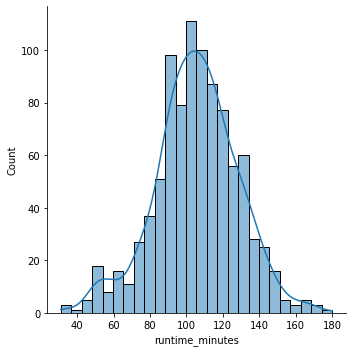

In [13]:
#Histogram showing runtime minutes for movies that earned above average revenue
sns.displot(filtered_gross['runtime_minutes'], bins='auto', kde=True)

Text(0.5, 1.0, 'Movie Earnings in Relation to Movie Runtime')

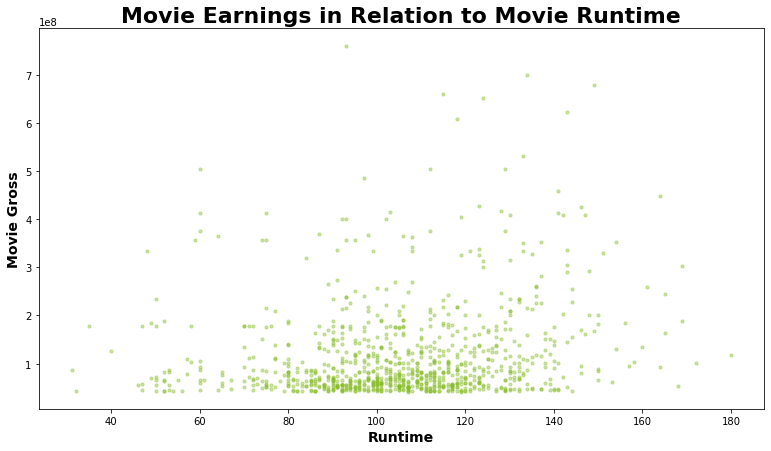

In [20]:
#Scatter plot visualization comparing revenue to movie length
filtered_gross.plot.scatter(x = 'runtime_minutes',y= 'domestic_gross',s = 10, c = '#86BC24', figsize=(13,7), alpha = 0.4)
plt.xlabel('Runtime', fontsize = 14, fontweight = 'bold')
plt.ylabel('Movie Gross', fontsize = 14, fontweight = 'bold')
plt.title('Movie Earnings in Relation to Movie Runtime', fontsize = 22, fontweight = 'bold')

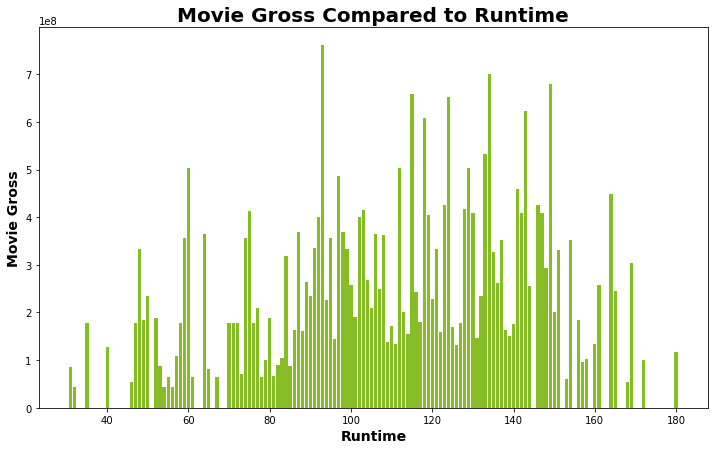

In [15]:
#
plt.figure(figsize=(12, 7))

plt.bar(filtered_gross['runtime_minutes'], filtered_gross['domestic_gross'], color = '#86BC24', edgecolor = 'none')
plt.title('Movie Gross Compared to Runtime', fontsize = 20, fontweight = 'bold')
plt.xlabel('Runtime', fontweight= 'bold', fontsize = 14)
plt.ylabel('Movie Gross', fontweight = 'bold', fontsize = 14)
plt.show()

In [16]:
minutes = [30, 60, 90, 120, 150, 180]
bin1 = range(30, 60)
bin2 = range(61, 90)
bin3 = range(91, 120)
bin4 = range(121, 150)
def f(row):
    if row['runtime_minutes'] in bin1:
        val = 'A'
    elif row['runtime_minutes'] in bin2:
        val = 'B'
    elif row['runtime_minutes'] in bin3:
        val = 'C'
    elif row['runtime_minutes'] in bin4:
        val = 'D'
    else:
        val = 'E'
    return val
filtered_gross['runtime_minutes_grouped'] = filtered_gross.apply(f, axis=1)
filtered_gross.head(25)

,domestic_gross,runtime_minutes,runtime_minutes_grouped
0,760507625,93,C
1,700059566,134,D
2,678815482,149,D
3,659363944,115,C
4,652270625,124,D
5,623279547,143,D
6,608581744,118,C
7,532177324,133,D
8,504014165,112,C
9,504014165,129,D


In [17]:
df_run = filtered_gross.groupby('runtime_minutes_grouped')['domestic_gross'].mean().reset_index()
df_run

,runtime_minutes_grouped,domestic_gross
0,A,1.067598e+08
1,B,9.630135e+07
2,C,1.072987e+08
3,D,1.559560e+08
4,E,1.362772e+08


In [18]:
df_ordered = df_run.sort_values(['runtime_minutes_grouped','domestic_gross'], ascending=True)
df_ordered

,runtime_minutes_grouped,domestic_gross
0,A,1.067598e+08
1,B,9.630135e+07
2,C,1.072987e+08
3,D,1.559560e+08
4,E,1.362772e+08


# Visualization Chart Analysis
We created a bar chart to help show the movie runtimes in comparison to the domestic gross for each movie in 30 minute increments to help show the relationship.

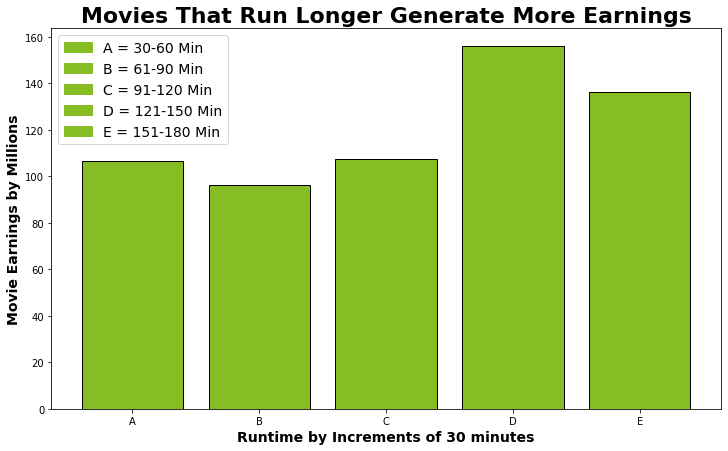

In [19]:
import matplotlib.patches as mpatches
plt.figure(figsize = (12, 7)) #adjusting the figure size of the bar graph
#Plotting a bar chart and dividing the domestic gross column by 1 million to have the y axis increments clearly defined
plt.bar(df_ordered['runtime_minutes_grouped'],df_ordered['domestic_gross']/1000000,align='center', edgecolor='black', color = '#86BC24')
plt.title('Movies That Run Longer Generate More Earnings', fontsize = 22, fontweight = 'bold') #plotting the title
plt.ylabel('Movie Earnings by Millions', fontsize = '14', fontweight = 'bold') #plotting the y axis label
plt.xlabel('Runtime by Increments of 30 minutes', fontsize = '14', fontweight = 'bold') #plotting the x axis label


patch1 = mpatches.Patch(color = '#86BC24', label= 'A = 30-60 Min')
patch2 = mpatches.Patch(color = '#86BC24', label = 'B = 61-90 Min')
patch3 = mpatches.Patch(color = '#86BC24', label = 'C = 91-120 Min')
patch4 = mpatches.Patch(color = '#86BC24', label = 'D = 121-150 Min')
patch5 = mpatches.Patch(color = '#86BC24', label = 'E = 151-180 Min')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], fontsize = 14)

Based off of the above analysis and visualizations, we suggest making movies between 121 and 150 minutes in length to maximize profits. Taking into account the top 990 grossing movies that are between 30 minutes and 300 minutes in length.